In [39]:
import argparse
import datetime
import logging
import os
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib widget
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pdb
import spc
import xarray
import yaml
from matplotlib.colors import BoundaryNorm, ListedColormap
from scipy import spatial
import seaborn as sns
from tensorflow import is_tensor
from tensorflow.keras.models import load_model

from ml_functions import (
    brier_skill_score,
    get_argparser,
    get_features,
    rptdist2bool,
    savedmodel_default,
)

In [2]:
def configs_match(ylargs, args):
    if args.kfold > 1:
        # once I started KFold. Training and testing cases are all before train_test_split_time with KFold.
        pass
    else:
        assert ylargs.splittime == args.splittime, f"yaml train_test_split_time {ylargs.splittime} does not match value from this script {args.splittime}"
    for key in ["batchnorm","batchsize","debug","dropout","epochs","flash","glm","kfold","layers","learning_rate","model","neurons",
            "optimizer","reg_penalty","rptdist", "suite", "twin"]:
        if key == "debug" and debug: continue # if running in debug mode, don't require debug in yaml file to match
        assert getattr(ylargs,key) == getattr(args,key), f'this script {key} {getattr(args,key)} does not match yaml {key} {getattr(ylargs,key)}'

    return True
def readcm(name):
    '''Read colormap from file formatted as 0-1 RGB CSV'''
    rgb = []
    fh = open(name, 'r')
    for line in fh.read().splitlines(): rgb.append(list(map(float,line.split()))) #added list for python3
    return rgb

def readNCLcm(name):

    rgb, appending = [], False
    rgb_dir_ch = '/glade/u/apps/ch/opt/ncl/6.4.0/intel/16.0.3/lib/ncarg/colormaps'
    fh = open('%s/%s.rgb'%(rgb_dir_ch,name), 'r')
    for line in list(fh.read().splitlines()):
        if appending: rgb.append(list(map(float,line.split())))
        if ''.join(line.split()) in ['#rgb',';RGB']: appending = True
    maxrgb = max([ x for y in rgb for x in y ])
    if maxrgb > 1: rgb = [ [ x/255.0 for x in a ] for a in rgb ]
    return rgb

In [3]:
def get_ax(fig):
    ax = fig.add_axes([x,y,w,h], projection=axes_proj)
    for i in ax.spines.items(): i[1].set_linewidth(0.5)

    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.3)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.3)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.1)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), edgecolor='k', linewidth=0.25, facecolor='k', alpha=0.1)
    domains = { 'CONUS' : [-120.81058,-75.4,23.159264,49.4],
                'SGP'   : [-109,-86,25.5,38],
                'NGP'   : [-108,-86,40,49.80],
                'CGP'   : [-108.50,-86.60,33,45],
                'NW'    : [-124,-102.1,39,49],
                'SW'    : [-122,-101,31,42],
                'SE'    : [-96,-77,26.75,37],
                'NE'    : [-92,-69,39,47.5],
                'MATL'  : [-92,-72,33.5,41.50] }

    ax.set_extent(domains["CONUS"])
    return ax



In [4]:
def get_scores(args):
    savedmodel = savedmodel_default(args, fhr_str="f01-f48")
    ifile = f"nn/nn_{savedmodel}.1fold.daily.scores.txt"
    scores = pd.read_csv(ifile, parse_dates=["init_time"], dtype={"class":str, "mem":str, "fold":str, "fhr":str})
    scores["init_time"] = scores["init_time"].dt.tz_localize('UTC')
    scores = scores[(scores.mem == "ensmean") & (scores.fhr == "all")] # & (scores["class"] == "torn_rptdist_2hr")]
    scores["new"] = scores["bss"] + scores["auc"] + scores["aps"]
    scores = scores.set_index("init_time")
    return scores

In [5]:
model = "NSC3km-12sec"
train_test_split_time = pd.to_datetime("20160701", utc=True)

ifile0 = f"{model}.par"
print(f"reading {ifile0}")
df0 = pd.read_parquet(ifile0, engine="pyarrow")
print("make valid_time timezone-aware")
df0["valid_time"] = df0.index.get_level_values(level="valid_time").tz_localize('UTC')
df0 = df0.droplevel("valid_time")
df0 = df0.set_index("valid_time", append=True)
df0 = df0.reorder_levels(["valid_time", "y", "x"])
print(f"making initialization_time timezone-aware") 
df0["initialization_time"] = df0["initialization_time"].dt.tz_localize('UTC')
print(f"and add to MultiIndex")
df0 = df0.set_index("initialization_time", append=True)
df0 = df0.sort_index(level="valid_time")
df0 = df0.loc[:,:,:,train_test_split_time:]
rptdist, twin = 40, 2
print(f"rptdist2bool {rptdist} {twin}")
df0, rptcols = rptdist2bool(df0, rptdist, twin)
labels = df0[rptcols]
df0 = df0.drop(columns=rptcols)

reading NSC3km-12sec.par
make valid_time timezone-aware
making initialization_time timezone-aware
and add to MultiIndex
rptdist2bool 40 2


In [6]:
parser = get_argparser()
args, argv = parser.parse_known_args()
args.model = model
args.epochs = 10
debug = False
kfold = 1
args.kfold = kfold
args.layers = 1
args.learning_rate = 0.01
args.neurons = [1024]
args.optimizer = 'sgd'
args.splittime = train_test_split_time
args.suite = "with_CNN_DNN_storm_mode_nprob"

In [7]:
scores = get_scores(args)
import copy

args0 = copy.deepcopy(args)
args0.suite = "default"
scores0 = get_scores(args0)

In [8]:
train_test_split_time

Timestamp('2016-07-01 00:00:00+0000', tz='UTC')

In [9]:
xx = pd.concat([scores,scores0], keys=["mode","default"],names=["suite","init_time"])
xx

class      mem fold  fhr  \
suite   init_time                                                           
mode    2016-07-04 00:00:00+00:00  sighail_rptdist_2hr  ensmean  all  all   
        2016-07-04 00:00:00+00:00  sigwind_rptdist_2hr  ensmean  all  all   
        2016-07-04 00:00:00+00:00  hailone_rptdist_2hr  ensmean  all  all   
        2016-07-04 00:00:00+00:00     wind_rptdist_2hr  ensmean  all  all   
        2016-07-04 00:00:00+00:00     torn_rptdist_2hr  ensmean  all  all   
...                                                ...      ...  ...  ...   
default 2019-05-20 00:00:00+00:00  sigwind_rptdist_2hr  ensmean  all  all   
        2019-05-20 00:00:00+00:00  hailone_rptdist_2hr  ensmean  all  all   
        2019-05-20 00:00:00+00:00     wind_rptdist_2hr  ensmean  all  all   
        2019-05-20 00:00:00+00:00     torn_rptdist_2hr  ensmean  all  all   
        2019-05-20 00:00:00+00:00      any_rptdist_2hr  ensmean  all  all   

                                        bss  base rate       auc       aps  \
suite   init_time                                                            
mode    2016-07-04 00:00:00+00:00  0.014241   0.000321  0.982923  0.037570   
        2016-07-04 00:00:00+00:00  0.013151   0.001156  0.957552  0.039387   
        2016-07-04 00:00:00+00:00  0.022672   0.001605  0.949088  0.078601   
        2016-07-04 00:00:00+00:00  0.096948   0.009919  0.936851  0.179934   
        2016-07-04 00:00:00+00:00  0.011304   0.000674  0.952291  0.023961   
...                                     ...        ...       ...       ...   
default 2019-05-20 00:00:00+00:00 -0.035025   0.000642  0.990881  0.038346   
        2019-05-20 00:00:00+00:00  0.148520   0.005265  0.983774  0.281804   
        2019-05-20 00:00:00+00:00  0.085418   0.006260  0.972594  0.148459   
        2019-05-20 00:00:00+00:00  0.084744   0.002568  0.985544  0.131535   
        2019-05-20 00:00:00+00:00  0.210845   0.010657  0.980040  0.308661   

                                        new  
suite   init_time                            
mode    2016-07-04 00:00:00+00:00  1.034734  
        2016-07-04 00:00:00+00:00  1.010089  
        2016-07-04 00:00:00+00:00  1.050360  
        2016-07-04 00:00:00+00:00  1.213733  
        2016-07-04 00:00:00+00:00  0.987555  
...                                     ...  
default 2019-05-20 00:00:00+00:00  0.994201  
        2019-05-20 00:00:00+00:00  1.414097  
        2019-05-20 00:00:00+00:00  1.206471  
        2019-05-20 00:00:00+00:00  1.201823  
        2019-05-20 00:00:00+00:00  1.499546  

[2724 rows x 9 columns]

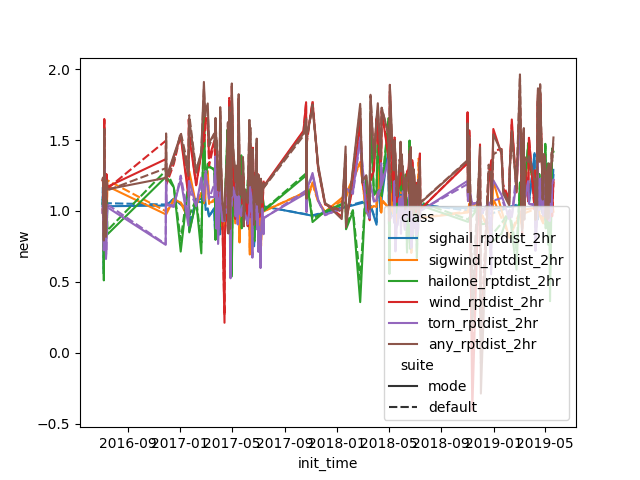

In [10]:
plt.clf()
ax = sns.lineplot(data=xx.reset_index(),x="init_time",y="new",style="suite",hue="class")
plt.show()

In [11]:
from importlib import reload
reload(spc)

<module 'spc' from '/glade/u/home/ahijevyc/.local/lib/python3.7/site-packages/spc.py'>

**Change idate, class_label, and event_type**

In [28]:
idate = pd.to_datetime("20190414", utc=True)
class_label, event_type = "torn_rptdist_2hr", "torn"



assert event_type in ["any", "hail", "high wind", "large hail", "torn", "wind"]

start = idate + datetime.timedelta(hours=12)
end = idate + datetime.timedelta(hours=36)
allrpts = spc.get_storm_reports(start=start, end=end, RyanSobashSanityCheck=True)

lonlat = df0[["lon","lat"]].groupby(["y","x"]).first().values
lon, lat = lonlat[:,0], lonlat[:,1]
tree = spatial.KDTree(lonlat) # don't get lon and lat from bad. they may not be in predictor suite
rpts = allrpts if event_type == "any" else allrpts[(allrpts["event_type"] == event_type)]
distances, closest = tree.query(rpts[["slon","slat"]])
closest = np.unique(closest)

tscores = scores[scores["class"] == class_label]
tscores0 = scores0[scores0["class"] == class_label]

In [11]:
def predict(args):
    df = df0[get_features(args)]
    savedmodel = savedmodel_default(args, fhr_str='f01-f48')

    sv = pd.read_pickle(f"scaling_values_{model}_{train_test_split_time:%Y%m%d_%H%M}.pk")

    # You might have scaling factors for columns that you dropped already, like -N7 columns.
    extra_sv_columns = set(sv.columns) - set(df.columns)
    if extra_sv_columns:
        sv = sv.drop(columns=extra_sv_columns)

    #df = df.xs(idate, level="initialization_time")
    features_max = df.groupby(["y","x","initialization_time"]).max()

    df = (df - sv.loc["mean"]) / sv.loc["std"]
    y_preds = pd.DataFrame()
    nfit = 5
    for thisfit in range(nfit):
        print(thisfit, end=' ')
        savedmodel_thisfit = f"nn/nn_{savedmodel}_{thisfit}/{kfold}fold0"
        yl = yaml.load(open(os.path.join(savedmodel_thisfit, "config.yaml"), "r"), Loader=yaml.Loader)
        yl_labels = yl["labels"]
        del(yl["labels"])
        #assert configs_match(yl["args"], args), f"this config {args} don't match yaml {yl['args']}"
        del(yl["args"])
        assert all(yl_labels == labels.columns)
        yl = pd.DataFrame(yl).set_index("columns").T
        nnmodel = load_model(savedmodel_thisfit, custom_objects=dict(brier_skill_score=brier_skill_score))
        Y = nnmodel.predict(df.to_numpy(dtype="float32"), batch_size=1298*12)
        Y = pd.DataFrame(Y, columns=labels.columns, index=df.index)
        Y = pd.concat([Y], keys=[thisfit], names=["fit"])
        y_preds = y_preds.append(Y)

    levels = list(y_preds.index.names)
    levels.remove("fit")
    ensmean = y_preds.groupby(level=levels).mean() # mean of fits
    ensmean_max = ensmean.groupby(["y","x","initialization_time"]).max() # max of fhrs
    return savedmodel, features_max, ensmean, ensmean_max

In [12]:
savedmodel0, features_max0, ensmean0, ensmean_max0 = predict(args0)
savedmodel, features_max, ensmean, ensmean_max = predict(args)

0 

2022-10-21 08:32:36.729498: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-21 08:32:36.729578: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc52): /proc/driver/nvidia/version does not exist
2022-10-21 08:32:36.756950: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 08:32:54.253850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1 2 3 4 0 1 2 3 4 

In [13]:
savedmodel0, savedmodel

('NSC3km-12sec.default.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.1layer.SGD.L20.01.lr0.01.0.0',
 'NSC3km-12sec.with_CNN_DNN_storm_mode_nprob.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.1layer.SGD.L20.01.lr0.01.0.0')

# Highest supercell probability

In [14]:
(features_max["DNN_1_Supercell_nprob"] + features_max["CNN_1_Supercell_nprob"]).groupby("initialization_time").max().sort_values(ascending=False)

initialization_time
2019-04-07 00:00:00+00:00    1.114498
2017-05-24 00:00:00+00:00    1.078893
2019-05-02 00:00:00+00:00    1.052594
2017-07-05 00:00:00+00:00    1.035177
2018-06-11 00:00:00+00:00    1.024295
                               ...   
2018-11-01 00:00:00+00:00    0.000000
2018-11-05 00:00:00+00:00    0.000000
2018-12-27 00:00:00+00:00    0.000000
2018-12-31 00:00:00+00:00    0.000000
2017-10-15 00:00:00+00:00    0.000000
Length: 227, dtype: float32

While tornado probability *is* positively correlated with supercells ...

# Greatest probability difference

In [16]:
((ensmean - ensmean0)**2).groupby("initialization_time").mean().sum(axis=1).sort_values(ascending=False).head(10)

initialization_time
2019-04-14 00:00:00+00:00    0.000128
2017-03-01 00:00:00+00:00    0.000122
2017-01-22 00:00:00+00:00    0.000119
2016-07-06 00:00:00+00:00    0.000106
2017-04-05 00:00:00+00:00    0.000099
2017-01-21 00:00:00+00:00    0.000084
2019-01-19 00:00:00+00:00    0.000081
2019-04-13 00:00:00+00:00    0.000077
2016-11-28 00:00:00+00:00    0.000074
2017-05-27 00:00:00+00:00    0.000073
dtype: float32

# Best combined stat improvement

In [17]:
ww = (scores.reset_index().set_index(["init_time","class"])[["bss","auc","aps"]] - scores0.reset_index().set_index(["init_time","class"])[["bss","auc","aps"]])
ww["new"] = ww["bss"] + ww["auc"] + ww["aps"]
ww.sort_values("new", ascending=False).head(20)

bss       auc       aps  \
init_time                 class                                               
2018-12-31 00:00:00+00:00 wind_rptdist_2hr     0.040043  0.000890  0.113839   
                          torn_rptdist_2hr     0.008314  0.001079  0.134457   
                          any_rptdist_2hr      0.037242  0.000977  0.102260   
                          sigwind_rptdist_2hr  0.007161  0.001155  0.118635   
2018-04-06 00:00:00+00:00 sigwind_rptdist_2hr  0.014696  0.000253  0.100222   
                          wind_rptdist_2hr     0.016451  0.000539  0.072594   
2017-05-01 00:00:00+00:00 wind_rptdist_2hr     0.039540  0.000800  0.048620   
2018-11-30 00:00:00+00:00 wind_rptdist_2hr     0.023081  0.001732  0.062650   
2017-05-01 00:00:00+00:00 any_rptdist_2hr      0.035561  0.000726  0.047151   
2017-02-25 00:00:00+00:00 wind_rptdist_2hr     0.031625  0.000171  0.046123   
2017-01-22 00:00:00+00:00 torn_rptdist_2hr     0.007513  0.000609  0.058392   
2019-05-09 00:00:00+00:00 wind_rptdist_2hr     0.009980  0.000119  0.054083   
2019-02-12 00:00:00+00:00 any_rptdist_2hr      0.022942  0.000564  0.038650   
2018-03-20 00:00:00+00:00 hailone_rptdist_2hr  0.026764  0.000061  0.032281   
2019-04-13 00:00:00+00:00 torn_rptdist_2hr     0.017204  0.001075  0.039969   
2017-03-06 00:00:00+00:00 any_rptdist_2hr      0.028653  0.002237  0.023270   
2018-05-04 00:00:00+00:00 wind_rptdist_2hr     0.027758  0.000108  0.023769   
2017-03-09 00:00:00+00:00 wind_rptdist_2hr     0.018898  0.000726  0.031855   
2016-12-17 00:00:00+00:00 wind_rptdist_2hr     0.024609  0.001273  0.024975   
2018-05-30 00:00:00+00:00 sighail_rptdist_2hr  0.003706 -0.000210  0.046622   

                                                    new  
init_time                 class                          
2018-12-31 00:00:00+00:00 wind_rptdist_2hr     0.154772  
                          torn_rptdist_2hr     0.143850  
                          any_rptdist_2hr      0.140479  
                          sigwind_rptdist_2hr  0.126950  
2018-04-06 00:00:00+00:00 sigwind_rptdist_2hr  0.115170  
                          wind_rptdist_2hr     0.089584  
2017-05-01 00:00:00+00:00 wind_rptdist_2hr     0.088960  
2018-11-30 00:00:00+00:00 wind_rptdist_2hr     0.087463  
2017-05-01 00:00:00+00:00 any_rptdist_2hr      0.083438  
2017-02-25 00:00:00+00:00 wind_rptdist_2hr     0.077918  
2017-01-22 00:00:00+00:00 torn_rptdist_2hr     0.066514  
2019-05-09 00:00:00+00:00 wind_rptdist_2hr     0.064182  
2019-02-12 00:00:00+00:00 any_rptdist_2hr      0.062155  
2018-03-20 00:00:00+00:00 hailone_rptdist_2hr  0.059107  
2019-04-13 00:00:00+00:00 torn_rptdist_2hr     0.058248  
2017-03-06 00:00:00+00:00 any_rptdist_2hr      0.054160  
2018-05-04 00:00:00+00:00 wind_rptdist_2hr     0.051635  
2017-03-09 00:00:00+00:00 wind_rptdist_2hr     0.051479  
2016-12-17 00:00:00+00:00 wind_rptdist_2hr     0.050858  
2018-05-30 00:00:00+00:00 sighail_rptdist_2hr  0.050117

In [18]:
scores.reset_index().set_index(["init_time","class"])

mem fold  fhr       bss  \
init_time                 class                                              
2016-07-04 00:00:00+00:00 sighail_rptdist_2hr  ensmean  all  all  0.014241   
                          sigwind_rptdist_2hr  ensmean  all  all  0.013151   
                          hailone_rptdist_2hr  ensmean  all  all  0.022672   
                          wind_rptdist_2hr     ensmean  all  all  0.096948   
                          torn_rptdist_2hr     ensmean  all  all  0.011304   
...                                                ...  ...  ...       ...   
2019-05-20 00:00:00+00:00 sigwind_rptdist_2hr  ensmean  all  all -0.034238   
                          hailone_rptdist_2hr  ensmean  all  all  0.148228   
                          wind_rptdist_2hr     ensmean  all  all  0.091505   
                          torn_rptdist_2hr     ensmean  all  all  0.090899   
                          any_rptdist_2hr      ensmean  all  all  0.216136   

                                               base rate       auc       aps  \
init_time                 class                                                
2016-07-04 00:00:00+00:00 sighail_rptdist_2hr   0.000321  0.982923  0.037570   
                          sigwind_rptdist_2hr   0.001156  0.957552  0.039387   
                          hailone_rptdist_2hr   0.001605  0.949088  0.078601   
                          wind_rptdist_2hr      0.009919  0.936851  0.179934   
                          torn_rptdist_2hr      0.000674  0.952291  0.023961   
...                                                  ...       ...       ...   
2019-05-20 00:00:00+00:00 sigwind_rptdist_2hr   0.000642  0.991419  0.037935   
                          hailone_rptdist_2hr   0.005265  0.984235  0.285603   
                          wind_rptdist_2hr      0.006260  0.972406  0.151750   
                          torn_rptdist_2hr      0.002568  0.986224  0.143717   
                          any_rptdist_2hr       0.010657  0.980040  0.321657   

                                                    new  
init_time                 class                          
2016-07-04 00:00:00+00:00 sighail_rptdist_2hr  1.034734  
                          sigwind_rptdist_2hr  1.010089  
                          hailone_rptdist_2hr  1.050360  
                          wind_rptdist_2hr     1.213733  
                          torn_rptdist_2hr     0.987555  
...                                                 ...  
2019-05-20 00:00:00+00:00 sigwind_rptdist_2hr  0.995115  
                          hailone_rptdist_2hr  1.418066  
                          wind_rptdist_2hr     1.215661  
                          torn_rptdist_2hr     1.220841  
                          any_rptdist_2hr      1.517832  

[1362 rows x 8 columns]

In [19]:
df0.index, ensmean.index

(MultiIndex([('2016-07-04 12:00:00+00:00', 21, 33, '2016-07-04 00:00:00+00:00'),
             ('2016-07-04 12:00:00+00:00', 21, 34, '2016-07-04 00:00:00+00:00'),
             ('2016-07-04 12:00:00+00:00', 21, 35, '2016-07-04 00:00:00+00:00'),
             ('2016-07-04 12:00:00+00:00', 21, 36, '2016-07-04 00:00:00+00:00'),
             ('2016-07-04 12:00:00+00:00', 22, 29, '2016-07-04 00:00:00+00:00'),
             ('2016-07-04 12:00:00+00:00', 22, 30, '2016-07-04 00:00:00+00:00'),
             ('2016-07-04 12:00:00+00:00', 22, 31, '2016-07-04 00:00:00+00:00'),
             ('2016-07-04 12:00:00+00:00', 22, 32, '2016-07-04 00:00:00+00:00'),
             ('2016-07-04 12:00:00+00:00', 22, 33, '2016-07-04 00:00:00+00:00'),
             ('2016-07-04 12:00:00+00:00', 22, 34, '2016-07-04 00:00:00+00:00'),
             ...
             ('2019-05-21 11:00:00+00:00', 78, 40, '2019-05-20 00:00:00+00:00'),
             ('2019-05-21 11:00:00+00:00', 78, 41, '2019-05-20 00:00:00+00:00'),
           

In [20]:
# Combine feature and predictions DataFrames
adf0 = pd.concat([df0.iloc[:,170:], ensmean0], axis="columns")
adf = pd.concat([df0.iloc[:,170:], ensmean], axis="columns")

In [21]:
hi_S = adf["DNN_1_Supercell_nprob"] >= 0.001
QLCS_groups = pd.cut(adf.loc[hi_S,"DNN_1_QLCS_nprob"], np.arange(0, 1.25, .25))

In [22]:
# Mean features and predictions as function of probability of QLCS (0-25%, 25-50%, 50-75%, 75-100%)
adf.loc[hi_S].groupby(QLCS_groups).mean().iloc[:,18:]

,DNN_1_Supercell_prob,DNN_1_Supercell,DNN_1_Supercell_nprob,DNN_1_QLCS_prob,DNN_1_QLCS,DNN_1_QLCS_nprob,DNN_1_Disorganized_prob,DNN_1_Disorganized,DNN_1_Disorganized_nprob,dayofyear_sin,dayofyear_cos,Local_Solar_Hour_sin,Local_Solar_Hour_cos,sighail_rptdist_2hr,sigwind_rptdist_2hr,hailone_rptdist_2hr,wind_rptdist_2hr,torn_rptdist_2hr,any_rptdist_2hr
DNN_1_QLCS_nprob,,,,,,,,,,,,,,,,,,,
"(0.0, 0.25]",0.034148,0.046987,0.044723,0.010013,0.014521,0.030341,0.066924,0.073181,0.067976,0.445576,-0.595114,-0.586663,-0.040024,0.013122,0.015608,0.069985,0.091365,0.020658,0.139153
"(0.25, 0.5]",0.007075,0.009259,0.028768,0.498094,0.689352,0.326130,0.045655,0.049537,0.067984,0.488073,-0.500189,-0.567725,-0.000724,0.016703,0.025565,0.079041,0.159242,0.035235,0.209079
"(0.5, 0.75]",0.000000,0.000000,0.015000,0.743232,0.994152,0.580408,0.034112,0.035088,0.058372,0.548987,-0.307172,-0.439065,-0.106637,0.009938,0.018799,0.048685,0.130063,0.027486,0.161741
"(0.75, 1.0]",0.000000,0.000000,0.002384,0.865652,1.000000,0.817893,0.000000,0.000000,0.038149,0.848501,-0.056734,-0.154462,-0.527535,0.003711,0.009022,0.024324,0.053533,0.014113,0.078092


### class_label was set earlier above

In [42]:
ensmean_max[class_label].xs(idate, level="initialization_time")

y   x 
21  33    0.000014
    34    0.000013
    35    0.000013
    36    0.000013
22  29    0.000029
            ...   
79  41    0.001083
    42    0.000886
    43    0.000298
    44    0.000029
80  41    0.000314
Name: torn_rptdist_2hr, Length: 1298, dtype: float32

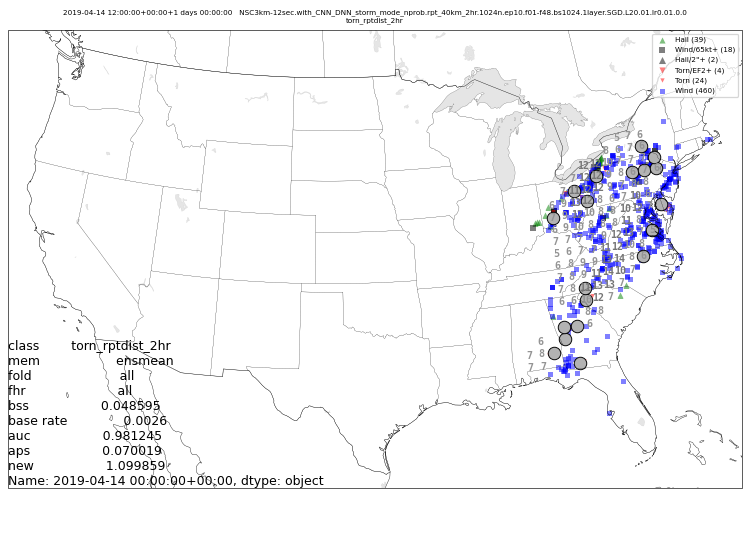

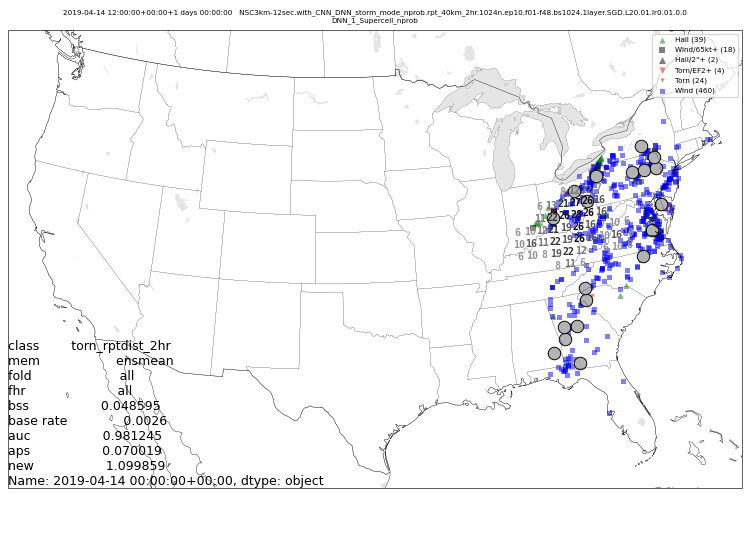

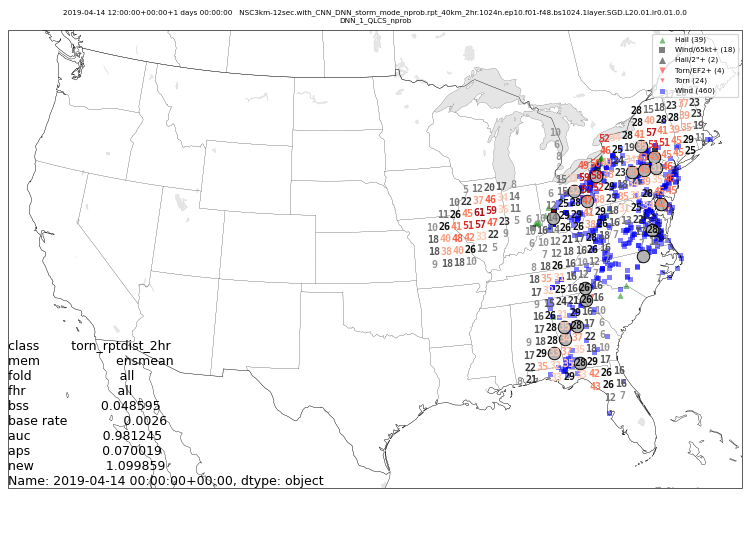

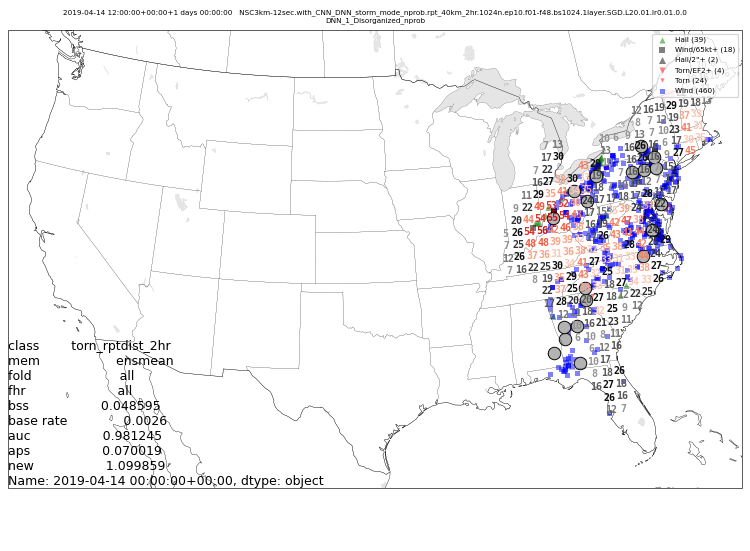

In [43]:
aspect = 0.6231716825706464 #only for US
#dpi, fig_width_pixels = 90, 1080
dpi, fig_width_pixels = 90, 750
fig_width  = fig_width_pixels/float(dpi)
fig_height = fig_width * aspect + 0.93
x,y,w,h = 0.01, 0.7/float(fig_height), 0.98, 0.98 * fig_width * aspect/float(fig_height) 
axes_proj = ccrs.LambertConformal(central_longitude=-101,central_latitude=38.33643,standard_parallels=(32,46))
test = readNCLcm('MPL_Greys')[50::] + [[1,1,1]] + readNCLcm('MPL_Reds')[20::]
cmap = ListedColormap(test)
plot_thresh = 0.05
norm = BoundaryNorm(np.arange(0,plot_thresh*15,plot_thresh), ncolors=cmap.N, clip=True)

fields = [ensmean_max[class_label].xs(idate, level="initialization_time")]
for f in ["DNN_1_Supercell_nprob", "DNN_1_QLCS_nprob", "DNN_1_Disorganized_nprob"]:
    if f in features_max:
        fields.append(features_max[f].xs(idate, level="initialization_time"))
    
for field in fields:
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    ax = get_ax(fig)
    ax.set_title(f"{start}+{end-start}   {savedmodel}\n{field.name}", fontsize="xx-small")
    ax.text(0,0,f'{tscores.loc[idate]}', transform=ax.transAxes, ha="left", va="bottom")

    if not allrpts.empty:
        legend_items = spc.plot(allrpts, ax, scale=2)
        ax.legend(handles=legend_items.values(), fontsize='xx-small')


    ax.scatter(lon[closest], lat[closest], color="black", marker="o", s=100, lw=0.75, facecolors='0.7', edgecolors='k', transform=ccrs.PlateCarree())
    
    for i, b in enumerate(field):
        color = cmap(norm([b])[0])
        if not np.isnan(b) and not np.isinf(b) and b>plot_thresh:
            val = round(b*100)
            a = ax.text(lon[i], lat[i], val, fontsize=8, ha="center", va="center", family="monospace", 
                        color = color, fontweight="bold", transform=ccrs.PlateCarree())

/glade/u/home/ahijevyc/miniconda3/envs/tf/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/ahijevyc/miniconda3/envs/tf/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/ahijevyc/miniconda3/envs/tf/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


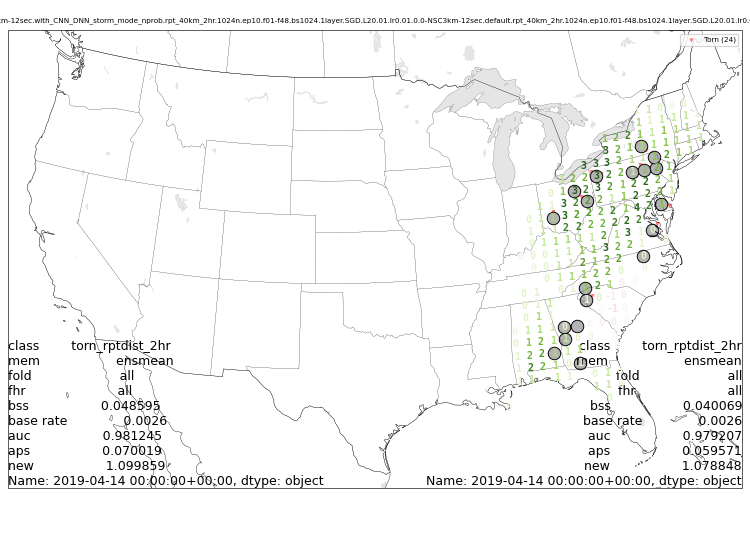

In [45]:
field = (ensmean_max - ensmean_max0)[class_label].xs(idate, level="initialization_time")
fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
ax = get_ax(fig)
ax.set_title(f"{savedmodel}-{savedmodel0}", fontsize="xx-small")
ax.text(0,0,f'{tscores.loc[idate]}', transform=ax.transAxes, ha="left", va="bottom")
ax.text(1,0,f'{tscores0.loc[idate]}', transform=ax.transAxes, ha="right", va="bottom")

if not rpts.empty:
    legend_items = spc.plot(rpts, ax, scale=2)
    ax.legend(handles=legend_items.values(), fontsize='xx-small')

ax.scatter(lon[closest], lat[closest], color="black", marker="o", s=100, lw=0.75, facecolors='0.7', edgecolors='k', transform=ccrs.PlateCarree())
cmap = plt.get_cmap("PiYG")
norm = BoundaryNorm(np.arange(-0.03,0.03,0.003), ncolors=cmap.N, clip=True)

for i, b in enumerate(field):
    color = cmap(norm([b])[0])
    if not np.isnan(b) and not np.isinf(b) and abs(b)>0.002:
        val = round(b*100)
        a = ax.text(lon[i], lat[i], val, fontsize=8, ha="center", va="center", family="monospace", 
                    color = color, fontweight="bold", transform=ccrs.PlateCarree())

In [46]:
rpts

,date_time,om,yr,mo,dy,tz,st,stf,stn,mag,...,f1,f2,f3,f4,fc,event_type,source,significant,time,mt
63989,2019-04-14 06:10:00,617243,2019,4,14,3,AL,1,0,1.0,...,109,0,0,0,0.0,torn,/glade/scratch/ahijevyc/1950-2020_actual_torna...,False,2019-04-14 12:10:00+00:00,NaN
63990,2019-04-14 08:14:00,617244,2019,4,14,3,AL,1,0,0.0,...,0,0,0,0,0.0,torn,/glade/scratch/ahijevyc/1950-2020_actual_torna...,False,2019-04-14 14:14:00+00:00,NaN
63991,2019-04-14 08:46:00,617245,2019,4,14,3,GA,13,0,0.0,...,215,145,263,0,0.0,torn,/glade/scratch/ahijevyc/1950-2020_actual_torna...,False,2019-04-14 14:46:00+00:00,NaN
63992,2019-04-14 09:39:00,617246,2019,4,14,3,GA,13,0,0.0,...,171,0,0,0,0.0,torn,/glade/scratch/ahijevyc/1950-2020_actual_torna...,False,2019-04-14 15:39:00+00:00,NaN
63993,2019-04-14 09:45:00,617247,2019,4,14,3,GA,13,0,1.0,...,171,255,0,0,0.0,torn,/glade/scratch/ahijevyc/1950-2020_actual_torna...,False,2019-04-14 15:45:00+00:00,NaN
63994,2019-04-14 12:43:00,617248,2019,4,14,3,GA,13,0,1.0,...,71,0,0,0,0.0,torn,/glade/scratch/ahijevyc/1950-2020_actual_torna...,False,2019-04-14 18:43:00+00:00,NaN
63995,2019-04-14 13:12:00,617249,2019,4,14,3,OH,39,0,0.0,...,23,0,0,0,0.0,torn,/glade/scratch/ahijevyc/1950-2020_actual_torna...,False,2019-04-14 19:12:00+00:00,NaN
63997,2019-04-14 15:15:00,617251,2019,4,14,3,OH,39,0,0.0,...,151,153,0,0,0.0,torn,/glade/scratch/ahijevyc/1950-2020_actual_torna...,False,2019-04-14 21:15:00+00:00,NaN
63998,2019-04-14 15:49:00,617252,2019,4,14,3,OH,39,0,0.0,...,157,0,0,0,0.0,torn,/glade/scratch/ahijevyc/1950-2020_actual_torna...,False,2019-04-14 21:49:00+00:00,NaN
63999,2019-04-14 16:48:00,617253,2019,4,14,3,PA,42,0,0.0,...,39,0,0,0,0.0,torn,/glade/scratch/ahijevyc/1950-2020_actual_torna...,False,2019-04-14 22:48:00+00:00,NaN


/glade/u/home/ahijevyc/miniconda3/envs/tf/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/u/home/ahijevyc/miniconda3/envs/tf/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/u/home/ahijevyc/miniconda3/envs/tf/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


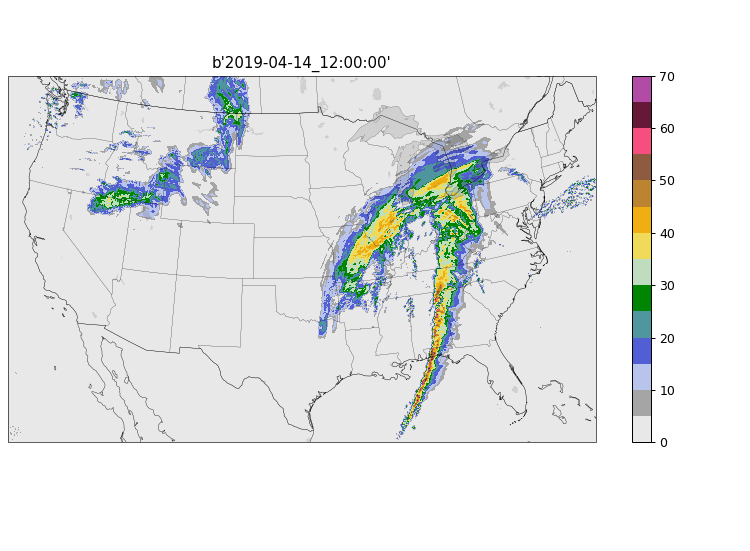

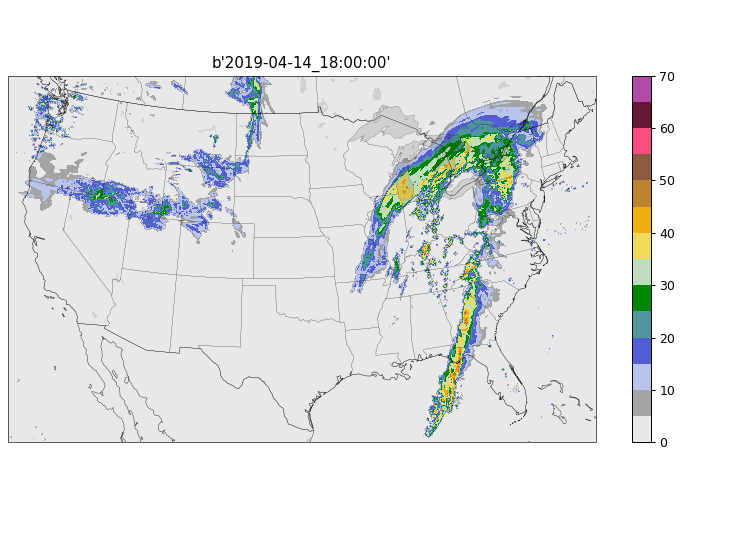

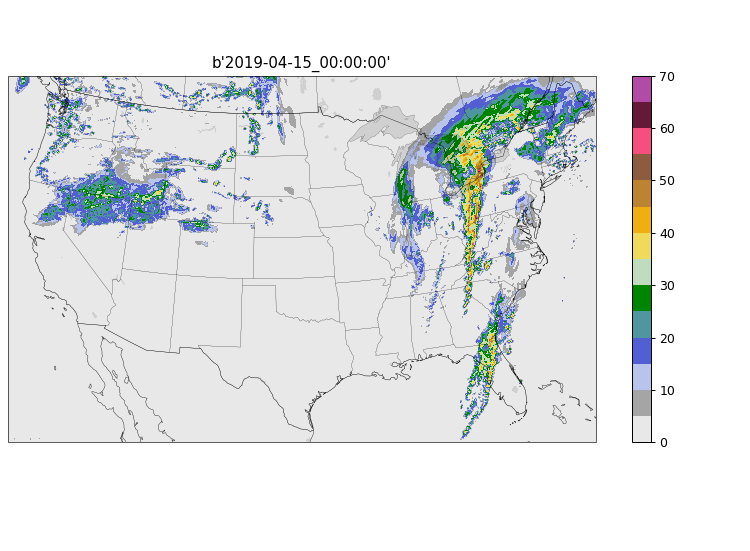

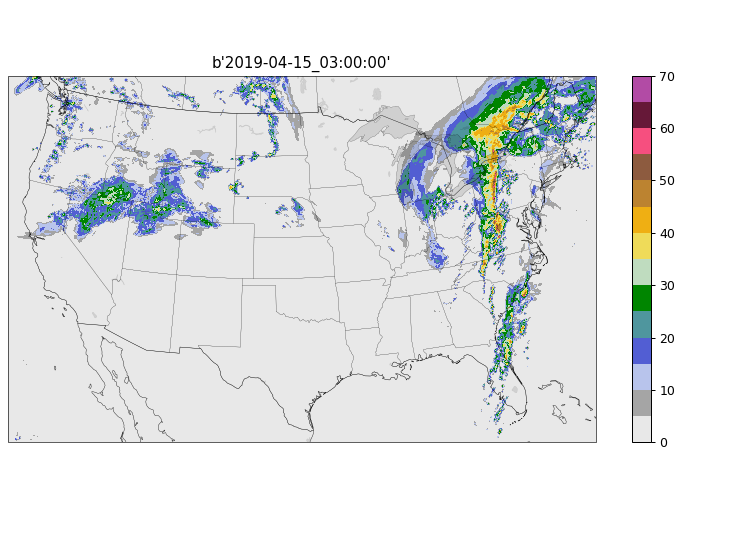

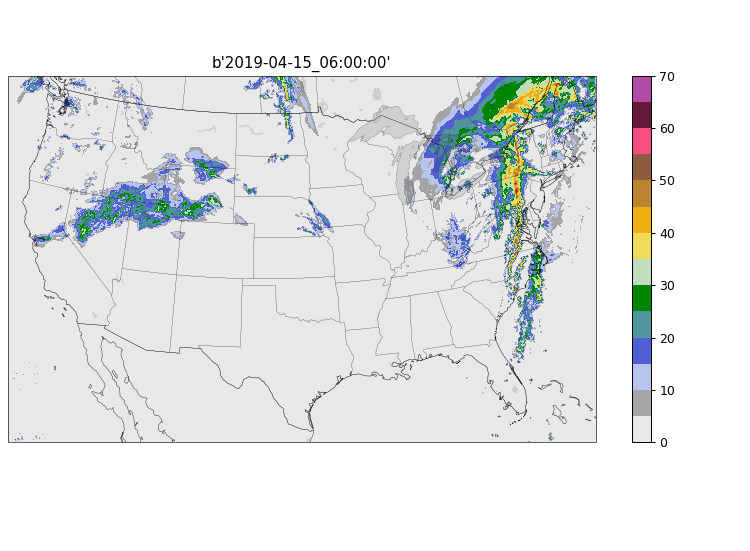

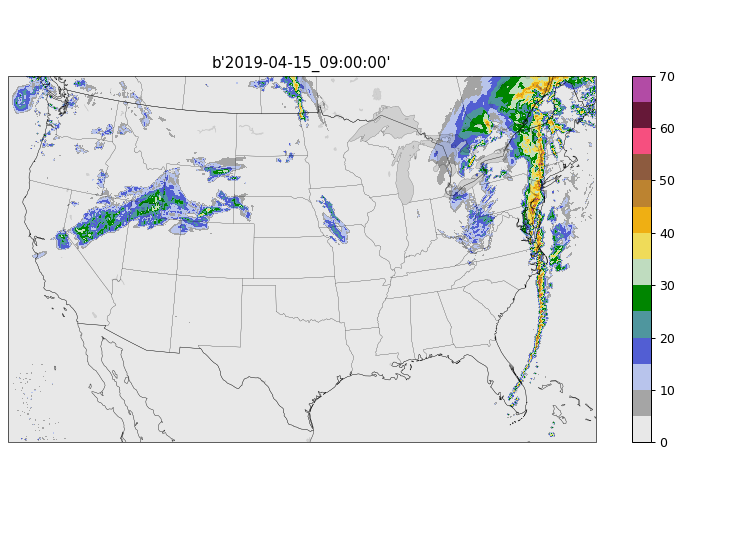

In [47]:
levels = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70]
refl_colors = readcm('/glade/u/home/sobash/RT2015_gpx/cmap_rad.rgb')[:14]
cmap = ListedColormap(refl_colors)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

paths = f'/glade/p/mmm/parc/sobash/NSC/3KM_WRF_POST_12sec_ts/{start:%Y%m%d00}/diags_d01_*.nc'
fh = xarray.open_mfdataset(paths, concat_dim="Time", combine="nested", data_vars=["REFL_COM"])
for itime in [12,18,24,27,30,33]:
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    ax = get_ax(fig)
    cref = fh['REFL_COM'].isel(Time=itime)
    img = ax.imshow(cref.values, origin="lower", cmap=cmap, norm=norm, extent=(-2071901.9869298763, 2663144.2246847088,-1465111.2368046804, 1489182.3023281314))
    plt.colorbar(img, shrink=0.8)
    ax.set_title(fh.Times.isel(Time=itime).load().data)